In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from IPython.display import display

import statsmodels.api as sm
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing

In [ ]:
# Check versions for SMOTE
'''
import scipy
print(scipy.__version__)
import sklearn
print(sklearn.__version__)
import imblearn
print(imblearn.__version__)
'''

'\nimport scipy\nprint(scipy.__version__)\nimport sklearn\nprint(sklearn.__version__)\nimport imblearn\nprint(imblearn.__version__)\n'

In [ ]:
def load_diabetes_data(path):
    # load in the original data
    diabetes_orig = pd.read_csv(path)

    # take just one person from each household
    diabetes = diabetes_orig.groupby("HHX") \
      .sample(1, random_state=24648765) \
      .reset_index() \
      .copy()
    # add an id column
    diabetes["id"] = np.arange(len(diabetes.index))
    # create the house_family_person_id column by joining together three ID columns
    diabetes["house_family_person_id"] = diabetes.apply(lambda x: "_".join(x[["HHX", "FMX", "FPX"]].astype(int).astype(str)),
                                                        axis=1)
    # create the diabetes column
    diabetes["diabetes"] = (diabetes["DIBEV1"] == 1).astype(int)
    # create coronary heart disease column
    diabetes["coronary_heart_disease"] = (diabetes["CHDEV"] == 1).astype(int)
    # create hypertension column
    diabetes["hypertension"] = (diabetes["HYPEV"] == 1).astype(int)
    # create heart_condition column
    diabetes["heart_condition"] = (diabetes["HRTEV"] == 1).astype(int)
    # create cancer column
    diabetes["cancer"] = (diabetes["CANEV"] == 1).astype(int)
    # create family_history_diabetes column
    diabetes["family_history_diabetes"] = (diabetes["DIBREL"] == 1).astype(int)
    # rename remaining relevant columns
    diabetes = diabetes.rename(columns={"AGE_P": "age",
                                      "SMKEV": "smoker",
                                      "SEX": "sex",
                                      "AWEIGHTP": "weight",
                                      "BMI": "bmi",
                                      "AHEIGHT": "height"})

    # select just the relevant columns
    diabetes = diabetes[["house_family_person_id",
                        "diabetes",
                        "age",
                        "smoker",
                        "sex",
                        "coronary_heart_disease",
                        "weight",
                        "bmi",
                        "height",
                        "hypertension",
                        "heart_condition",
                        "cancer",
                        "family_history_diabetes"]]
    return(diabetes)

In [ ]:
path = '../data/samadult_2017.csv'
df = load_diabetes_data(path)

In [ ]:
df

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
0,1_2_1,0,24,2,2,0,125,2019,66,0,0,0,0
1,2_1_1,0,76,2,1,0,190,2727,70,1,0,0,0
2,3_1_2,0,36,2,2,0,225,3862,64,0,0,0,1
3,5_1_1,0,35,1,2,0,240,3995,65,0,0,0,1
4,10_1_5,0,20,2,2,0,103,1883,62,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32494,71559_1_1,0,56,1,1,0,172,2399,71,0,0,1,1
32495,71565_1_1,0,58,1,1,0,225,3141,71,1,0,0,1
32496,71569_1_1,1,71,1,2,1,124,2501,59,1,0,0,1
32497,71576_1_1,0,64,1,1,0,188,2945,67,1,0,0,0


In [ ]:
# Create csv file of new df
#df.to_csv('diabetes.csv', index=False)

In [ ]:
# Checking for basic statistics and data information to understand the data better
data_info = df.info()
data_description = df.describe()

# Checking for missing values
missing_values = df.isnull().sum()

# Displaying the outputs
display(data_info, data_description, missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32499 entries, 0 to 32498
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   house_family_person_id   32499 non-null  object
 1   diabetes                 32499 non-null  int64 
 2   age                      32499 non-null  int64 
 3   smoker                   32499 non-null  int64 
 4   sex                      32499 non-null  int64 
 5   coronary_heart_disease   32499 non-null  int64 
 6   weight                   32499 non-null  int64 
 7   bmi                      32499 non-null  int64 
 8   height                   32499 non-null  int64 
 9   hypertension             32499 non-null  int64 
 10  heart_condition          32499 non-null  int64 
 11  cancer                   32499 non-null  int64 
 12  family_history_diabetes  32499 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 3.2+ MB


None

,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
count,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000,32499.000000
mean,0.107142,51.051017,1.608942,1.547494,0.055232,251.113850,3045.910736,68.817748,0.356042,0.089603,0.112865,0.354134
std,0.309298,18.511120,0.609761,0.497747,0.228437,240.280025,1451.552127,8.459210,0.478835,0.285616,0.316433,0.478257
min,0.000000,18.000000,1.000000,1.000000,0.000000,100.000000,1167.000000,59.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.000000,1.000000,1.000000,0.000000,150.000000,2374.000000,64.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,52.000000,2.000000,2.000000,0.000000,176.000000,2724.000000,67.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,66.000000,2.000000,2.000000,0.000000,214.000000,3173.000000,70.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,85.000000,9.000000,2.000000,1.000000,999.000000,9999.000000,99.000000,1.000000,1.000000,1.000000,1.000000


,0
house_family_person_id,0
diabetes,0
age,0
smoker,0
sex,0
coronary_heart_disease,0
weight,0
bmi,0
height,0
hypertension,0


In [ ]:
# Check random rows
display(df.sample(5))

# Check the anomily smoker counts
display(df['smoker'].value_counts())

,house_family_person_id,diabetes,age,smoker,sex,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes
19012,41541_1_1,0,58,2,1,0,210,3015,70,0,1,0,0
14035,30824_1_1,0,50,1,1,0,185,2654,70,0,0,0,0
16413,35913_1_1,1,54,1,1,0,270,4107,68,0,0,0,1
7611,16828_1_1,0,85,2,2,0,185,2813,68,1,0,0,0
23778,52093_1_1,0,41,2,1,0,198,2684,72,0,0,0,0


,count
smoker,
2,19071
1,13325
8,59
7,23
9,21


### Initial thoughts:
#### Data Structure:
- No missing values in any of the columns.
- The dataset includes 12 numerical columns and 1 object column (house_family_person_id).

#### Statistical Summary:

**Diabetes**: 10.7% of the individuals have diabetes.

**Age**: The age range is from 18 to 85, with an average of 51 years.

**Smoker**: The majority are non-smokers, but there are some anomalies with values exceeding 2, which might indicate errors.

**Sex**: There seems to be a roughly even split between male (1) and female (2) participants.

**Weight**: Ranges from 100 to 999 pounds, with an average around 251 pounds.
   - Extreme values (e.g., 999) suggest unreasonable outluers.

**BMI**: Varies from 1167 to 9999 (it appears the BMI has been scaled by a factor of 1000), with a mean of 3045 (or a BMI of 30.45 when scaled back).
   - Again, unreasonable outlier values here

**Height**: Ranges from 59 to 99 inches.
   - 99 inch could be possible but very unlikely, so adjust for that
    

Other health indicators:
- 35.6% have hypertension.
- 8.9% have heart conditions.
- 11.3% have cancer.
- 35.4% have a family history of diabetes.

**Potential Anomalies**:
- The smoker column has values above 2, which may represent errors. **Values > 2 will be assumed to be smokers.**

### Potential subsequent action items:
- make house_family_person_id numeric
- fix scale on BMI (divide by 100)
- fix inconsistent values in the smoker column
- standardize or normalize? (might not be necessary)
- OHE for the categorical variables; smoker and sex, and maybe for BMI and age (by using age bins)
- weight and bmi outliers: Values of 999 for weight and BMI, or extremely high values (e.g., 9999 BMI), suggest outliers or potential errors. You should review these values and decide whether to correct or remove them. This could be done via:
    - Outlier detection (e.g., based on interquartile ranges).
    - Reassessing if these entries represent real-world data (e.g., by calculating BMI from weight and height).
    - other ways?
- **Diabetes Imbalance**: Only about 10.7% of the individuals have diabetes. If you plan to build models for prediction, you may want to address this imbalance using:
    - Oversampling (e.g., SMOTE) or Undersampling.
- **Drop features we don't use** in the prediction part
   
   
    
    
Feature engineering:
- **Age Binning**: Since age has a clear relationship with diabetes, creating age bins (e.g., under 30, 30-50, 50+) to could make the data more interpretable and facilitate categorical analysis. This could help in understanding the risk of diabetes across different life stages.
- **BMI Categories**: Similarly, convert BMI into standard categories (e.g., underweight, normal, overweight, obese) based on medical guidelines. This could help in visual storytelling and improve model performance if you're using machine learning.

### Notes on OHE and SMOTE:
- **Purpose of One-Hot Encoding**: To transform categorical variables into a format that machine learning models can work with, without introducing unintended relationships between categories.
- **Why It’s Important**: It helps algorithms interpret the data correctly by treating each category as a separate, binary feature rather than assuming an arbitrary order or relationship between categories.
- **SMOTE**: Generates new synthetic examples rather than duplicating existing ones, which reduces the risk of overfitting and provides more diverse training data

In [ ]:
def prepareDiabetesData(df,
                          make_id_numeric=False,
                          rescale_bmi=True,
                          fix_smoker_values=True,
                          ohe_categorical=True,
                          handle_outliers=True,
                          handle_imbalance=False,
                          age_binning=True,
                          bmi_categorization=True):
    """
    Prepares the diabetes data based on action items.

    Parameters:
    df (pandas DataFrame): Input data
    make_id_numeric (bool): Whether to convert 'house_family_person_id' to numeric
    rescale_bmi (bool): Whether to fix BMI scale by dividing by 100
    fix_smoker_values (bool): Whether to fix inconsistent smoker values
    ohe_categorical (bool): Whether to perform one-hot encoding on categorical variables
        note: gender = 1 is Female, gender = 0 is Male
    handle_outliers (bool): Whether to handle outliers in 'weight' and 'bmi'
    handle_imbalance (bool): Whether to handle diabetes class imbalance using SMOTE
    age_binning (bool): Whether to bin ages
    bmi_categorization (bool): Whether to categorize BMI into standard ranges

    Returns:
    pandas DataFrame: Cleaned and processed data
    """

    # Create a copy of the dataframe to ensure the original is untouched
    df_cleaned = df.copy()

    # 1. Convert 'house_family_person_id' to numeric
    if make_id_numeric:
        df_cleaned['house_family_person_id'] = pd.factorize(df_cleaned['house_family_person_id'])[0]

    # 2. Fix BMI scale (divide by 100)
    if rescale_bmi:
        df_cleaned['bmi'] = df_cleaned['bmi'] / 100

    # 3. Fix inconsistent smoker values
    if fix_smoker_values:
        df_cleaned['smoker'] = df_cleaned['smoker'].apply(lambda x: 2 if x > 2 else x)

    # 4. Handle outliers for weight and BMI using IQR (before SMOTE)
    if handle_outliers:
        def clip_outliers(col):
            """Clips outliers using the IQR method (1.5*IQR rule)."""
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return col.clip(lower=lower_bound, upper=upper_bound)

        df_cleaned['weight'] = clip_outliers(df_cleaned['weight'])
        df_cleaned['bmi'] = clip_outliers(df_cleaned['bmi'])

    # 5. Handle Diabetes Class Imbalance using SMOTE (before any categorical transformations)
    if handle_imbalance:
        smote = SMOTE(random_state=42)
        X = df_cleaned.drop('diabetes', axis=1)
        y = df_cleaned['diabetes']
        X_res, y_res = smote.fit_resample(X, y)
        df_cleaned = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['diabetes'])], axis=1)

    # 6. Bin Ages into categories (after SMOTE)
    if age_binning:
        df_cleaned['age_bin'] = pd.cut(df_cleaned['age'], bins=[18, 30, 50, 85], labels=['Under 30', '30-50', '50+'])
        if ohe_categorical:
            df_age_ohe = pd.get_dummies(df_cleaned['age_bin'], prefix='age')
            df_cleaned = pd.concat([df_cleaned, df_age_ohe], axis=1)
            df_cleaned.drop('age_bin', axis=1, inplace=True)

    # 7. Categorize BMI into standard medical categories (after SMOTE)
    if bmi_categorization:
        df_cleaned['bmi_category'] = pd.cut(df_cleaned['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')],
                                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        if ohe_categorical:
            df_bmi_ohe = pd.get_dummies(df_cleaned['bmi_category'], prefix='bmi')
            df_cleaned = pd.concat([df_cleaned, df_bmi_ohe], axis=1)
            df_cleaned.drop('bmi_category', axis=1, inplace=True)

    # 8. One-Hot Encode categorical variables (smoker, sex, BMI, and age bins)
    if ohe_categorical:
        # Apply OHE to smoker and sex columns
        ohe = OneHotEncoder(drop='first', sparse_output=False)
        # One-hot encode 'smoker' and 'sex'
        df_ohe = pd.DataFrame(ohe.fit_transform(df_cleaned[['smoker', 'sex']]),
                              columns=ohe.get_feature_names_out(['smoker', 'sex']))


        # Convert one-hot encoded columns to integers (0 or 1)
        df_ohe = df_ohe.astype(int)

        # Concatenate the new one-hot encoded columns back to the original dataframe
        df_cleaned = pd.concat([df_cleaned, df_ohe], axis=1)

        # Drop the original 'smoker' and 'sex' columns
        df_cleaned.drop(['smoker', 'sex'], axis=1, inplace=True)

        # Rename for clarity
        df_cleaned.rename(columns={'smoker_2': 'smoker', 'sex_2': 'gender'}, inplace=True)

    return df_cleaned  # Return the cleaned dataframe

### Split model, then clean (with SMOTE on train, without SMOTE on test)

In [ ]:
df_cleaned = prepareDiabetesData(df,
                                 make_id_numeric=True,
                          rescale_bmi=True,
                          fix_smoker_values=True,
                          ohe_categorical=True,
                          handle_outliers=True,
                          handle_imbalance=False,
                          age_binning=True,
                          bmi_categorization=True)

In [ ]:
import statsmodels.api as sm

# Ensure categorical columns are properly encoded using one-hot encoding
df_cleaned_2 = df_cleaned

# Replace "true"/"false" with 1/0 in the specified columns
df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']] = df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']].replace({True: 1, False: 0})

df_cleaned_2.head()

<ipython-input-11-e21639480d22>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']] = df_cleaned_2[['age_Under 30', 'age_30-50', 'age_50+', 'smoker', 'gender']].replace({True: 1, False: 0})


,house_family_person_id,diabetes,age,coronary_heart_disease,weight,bmi,height,hypertension,heart_condition,cancer,family_history_diabetes,age_Under 30,age_30-50,age_50+,bmi_Underweight,bmi_Normal,bmi_Overweight,bmi_Obese,smoker,gender
0,0,0,24,0,125,20.19,66,0,0,0,0,1,0,0,False,True,False,False,1,1
1,1,0,76,0,190,27.27,70,1,0,0,0,0,0,1,False,False,True,False,1,0
2,2,0,36,0,225,38.62,64,0,0,0,1,0,1,0,False,False,False,True,1,1
3,3,0,35,0,240,39.95,65,0,0,0,1,0,1,0,False,False,False,True,0,1
4,4,0,20,0,103,18.83,62,0,0,0,1,1,0,0,False,True,False,False,1,1


In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Define independent (X) and dependent (y) variables
X = df_cleaned_2[['age', 'coronary_heart_disease', 'weight', 'bmi', 'height', 'hypertension',
                  'heart_condition', 'cancer', 'family_history_diabetes', 'smoker', 'gender']]
y = df_cleaned_2['diabetes']

# List of continuous variables and binary variables
continuous_vars = ['age', 'weight', 'bmi', 'height']
binary_vars = ['coronary_heart_disease', 'hypertension', 'heart_condition', 'cancer',
               'family_history_diabetes', 'smoker', 'gender']

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

## Prediction

### Logistic Regression

#### On balanced dataset (SMOTE)

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

# Step 3: Create interaction terms and polynomial features (degree 2)
# Apply PolynomialFeatures to both continuous and binary variables
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_res)
X_test_poly = poly.transform(X_test)

# Step 4: Scale only the continuous variables
scaler = StandardScaler()

# Extract continuous features from the polynomial transformation
continuous_indices = [i for i, col in enumerate(poly.get_feature_names_out(X.columns))
                      if any(var in col for var in continuous_vars)]
binary_indices = [i for i in range(len(poly.get_feature_names_out(X.columns))) if i not in continuous_indices]

# Scale only continuous variables in the transformed data
X_train_poly_continuous = X_train_poly[:, continuous_indices]
X_test_poly_continuous = X_test_poly[:, continuous_indices]

# Apply scaling to continuous features
X_train_poly_continuous_scaled = scaler.fit_transform(X_train_poly_continuous)
X_test_poly_continuous_scaled = scaler.transform(X_test_poly_continuous)

# Rebuild the full dataset, keeping the binary variables unscaled
X_train_scaled = X_train_poly.copy()
X_train_scaled[:, continuous_indices] = X_train_poly_continuous_scaled

X_test_scaled = X_test_poly.copy()
X_test_scaled[:, continuous_indices] = X_test_poly_continuous_scaled

# Step 5: Convert to DataFrame and add column names
# Get the feature names from PolynomialFeatures
feature_names = poly.get_feature_names_out(X.columns)

# Create DataFrame for scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Step 6: Add a constant term for the intercept
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

# Step 7: Reset indices to ensure alignment between X and y
X_train_scaled_df = X_train_scaled_df.reset_index(drop=True)
y_train_res = y_train_res.reset_index(drop=True)

# Step 8: Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train_res, X_train_scaled_df)
result = logit_model.fit()

# Step 9: Display the regression summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.474132
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                40650
Model:                          Logit   Df Residuals:                    40579
Method:                           MLE   Df Model:                           70
Date:                Tue, 05 Nov 2024   Pseudo R-squ.:                  0.3160
Time:                        00:38:36   Log-Likelihood:                -19273.
converged:                       True   LL-Null:                       -28176.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                              

In [ ]:
# Step 1: Get the model coefficients, standard errors, and p-values
params = result.params  # This gives you the coefficients
standard_errors = result.bse  # This gives you the standard errors (std dev)
p_values = result.pvalues  # This gives you the p-values

# Step 2: Select the first 11 regressors (plus the constant)
selected_params = params[:12]  # The first 11 regressors plus the constant
selected_standard_errors = standard_errors[:12]  # The standard errors for these
selected_p_values = p_values[:12]  # The p-values for these

# Step 3: Create a DataFrame to display the results, including p-values
summary_df = pd.DataFrame({
    'Regressor': selected_params.index,
    'Coefficient': selected_params.values,
    'Standard Error': selected_standard_errors.values,
    'p-value': selected_p_values.values
})

# Display the result
print(summary_df)

                  Regressor  Coefficient  Standard Error       p-value
0                     const     0.073676    1.245783e+00  9.528403e-01
1                       age     1.810699             NaN           NaN
2    coronary_heart_disease     1.177388             NaN           NaN
3                    weight    10.494421    9.338252e-01  2.650280e-29
4                       bmi    -7.944907    2.206947e+00  3.182749e-04
5                    height   -24.162918    2.604377e+00  1.729938e-20
6              hypertension    -0.160748    6.015839e+14  1.000000e+00
7           heart_condition    -1.058248             NaN           NaN
8                    cancer     0.092134             NaN           NaN
9   family_history_diabetes    -0.085843    1.279642e+15  1.000000e+00
10                   smoker     0.561797             NaN           NaN
11                   gender    -0.746628             NaN           NaN


In [ ]:
# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.5).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")

# Step 13: Calculate the accuracy score
accuracy = accuracy_score(y_test, logit_preds_test)
print(f"Accuracy (Logit Model on Test Data): {accuracy:.4f}")

F1 Score (Logit Model on Test Data): 0.3481
Accuracy (Logit Model on Test Data): 0.7392


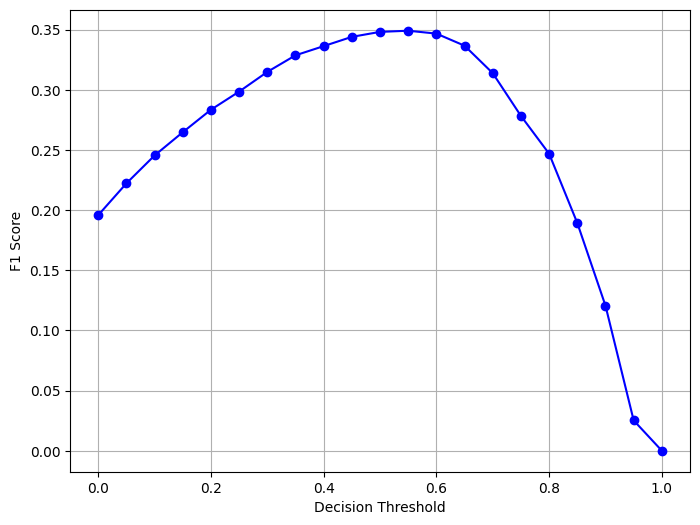

Best Threshold: 0.55, Best F1 Score: 0.3491


In [ ]:
# Step 11: Define thresholds and calculate F1 scores at each threshold
thresholds = np.arange(0, 1.05, 0.05)
f1_scores = []

for threshold in thresholds:
    # Step 12: Convert predicted probabilities to binary using the threshold
    logit_preds_test = (logit_probs_test >= threshold).astype(int)

    # Calculate the F1 score for the current threshold
    f1 = f1_score(y_test, logit_preds_test)
    f1_scores.append(f1)

# Step 13: Plot the evolution of F1 score for different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', color='blue')
#plt.title('F1 Score vs. Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('f1_score_vs_threshold.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 14: Find the threshold with the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1_score:.4f}")

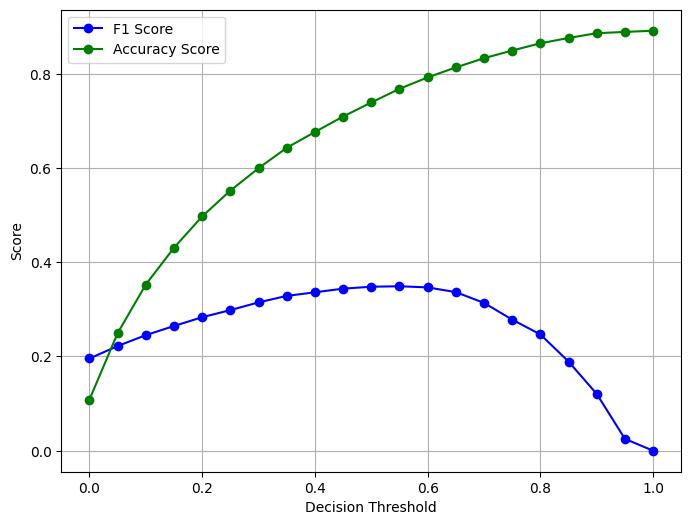

Best Threshold for F1 Score: 0.55, Best F1 Score: 0.3491
Best Threshold for Accuracy: 1.00, Best Accuracy Score: 0.8915


In [ ]:
from sklearn.metrics import accuracy_score

# Step 11: Define thresholds and calculate F1 and accuracy scores at each threshold
thresholds = np.arange(0, 1.05, 0.05)
f1_scores = []
accuracy_scores = []

for threshold in thresholds:
    # Step 12: Convert predicted probabilities to binary using the threshold
    logit_preds_test = (logit_probs_test >= threshold).astype(int)

    # Calculate the F1 score for the current threshold
    f1 = f1_score(y_test, logit_preds_test)
    f1_scores.append(f1)

    # Calculate the accuracy score for the current threshold
    accuracy = accuracy_score(y_test, logit_preds_test)
    accuracy_scores.append(accuracy)

# Step 13: Plot the evolution of F1 and accuracy scores for different thresholds
plt.figure(figsize=(8, 6))

# Plot F1 scores
plt.plot(thresholds, f1_scores, marker='o', color='blue', label='F1 Score')

# Plot accuracy scores
plt.plot(thresholds, accuracy_scores, marker='o', color='green', label='Accuracy Score')

plt.xlabel('Decision Threshold')
plt.ylabel('Score')
#plt.title('F1 Score and Accuracy vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.savefig('../output/f1_and_accuracy_vs_threshold_balanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 14: Find the threshold with the maximum F1 score
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best Threshold for F1 Score: {best_threshold_f1:.2f}, Best F1 Score: {best_f1_score:.4f}")

# Step 15: Find the threshold with the maximum accuracy
best_threshold_accuracy = thresholds[np.argmax(accuracy_scores)]
best_accuracy_score = max(accuracy_scores)

print(f"Best Threshold for Accuracy: {best_threshold_accuracy:.2f}, Best Accuracy Score: {best_accuracy_score:.4f}")

F1 Score (Logit Model on Test Data): 0.3440
AUC Score (Logit Model on Test Data): 0.7728


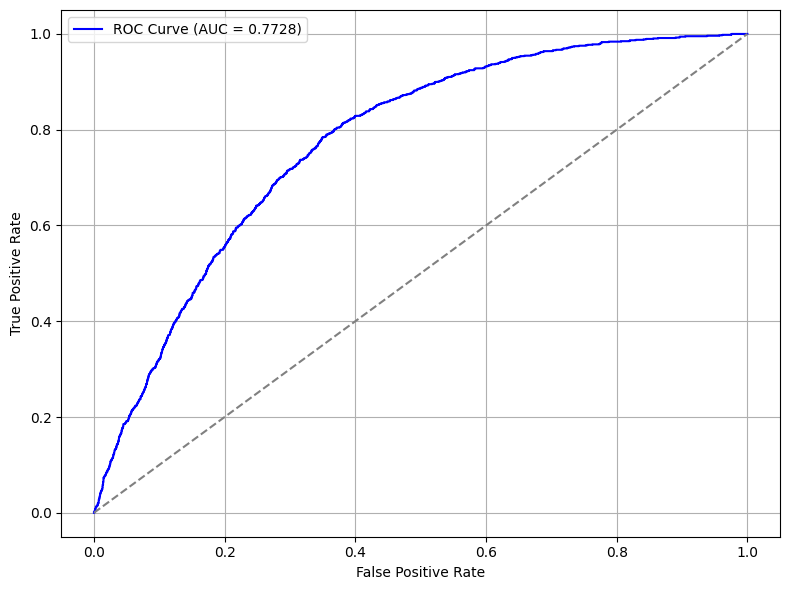

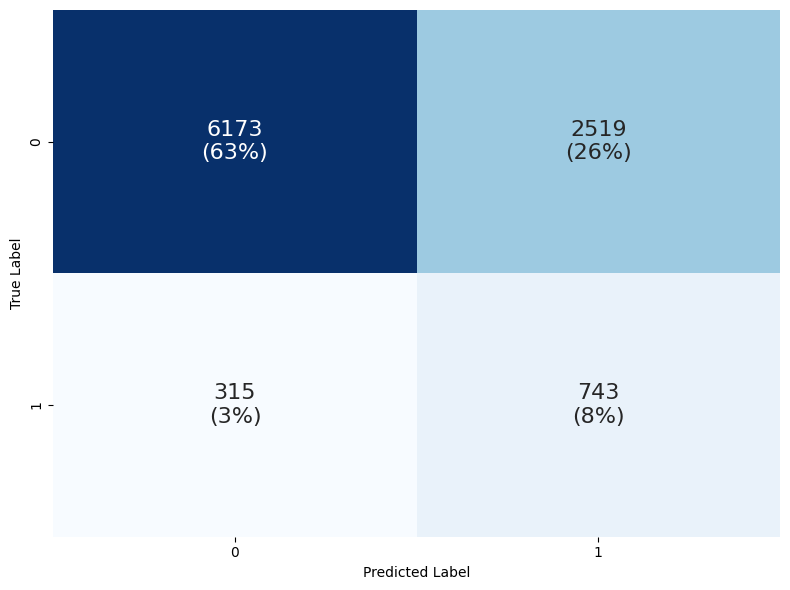

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.45).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")


# Step 13: ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, logit_probs_test)  # Get False Positive Rate and True Positive Rate
auc_score = roc_auc_score(y_test, logit_probs_test)  # AUC score
print(f"AUC Score (Logit Model on Test Data): {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Dashed diagonal line
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../output/logistic_regression_ROC_curve_balanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()


# Step 14: Confusion Matrix
cm = confusion_matrix(y_test, logit_preds_test)

# Step 15: Prepare counts and percentages for the confusion matrix
group_counts = [f"{value:0.0f}" for value in cm.flatten()]
group_percentages = [f"({value:.0%})" for value in cm.flatten() / np.sum(cm)]

# Step 16: Create combined labels with counts and percentages in brackets
labels = [f"{count}\n{percent}" for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Step 17: Plot the confusion matrix using seaborn heatmap with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Customizing the plot
#plt.title('Confusion Matrix with Counts and Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Display the plot
plt.tight_layout()
plt.savefig('../output/logistic_regression_confusion_matrix_balanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# Step 15: Calculate the marginal effects
marginal_effects = result.get_margeff(at='overall', method='dydx')  # Average marginal effects

# Step 16: Display the marginal effects summary
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:               diabetes
Method:                          dydx
At:                           overall
                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
age                                                0.2818        nan        nan        nan         nan         nan
coronary_heart_disease                             0.1833        nan        nan        nan         nan         nan
weight                                             1.6334        nan        nan        nan         nan         nan
bmi                                               -1.2366        nan        nan        nan         nan         nan
height                                            -3.7609        nan        nan        nan         nan         nan
hypertension                               

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))


<ipython-input-21-b50cbe6441e4>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index,


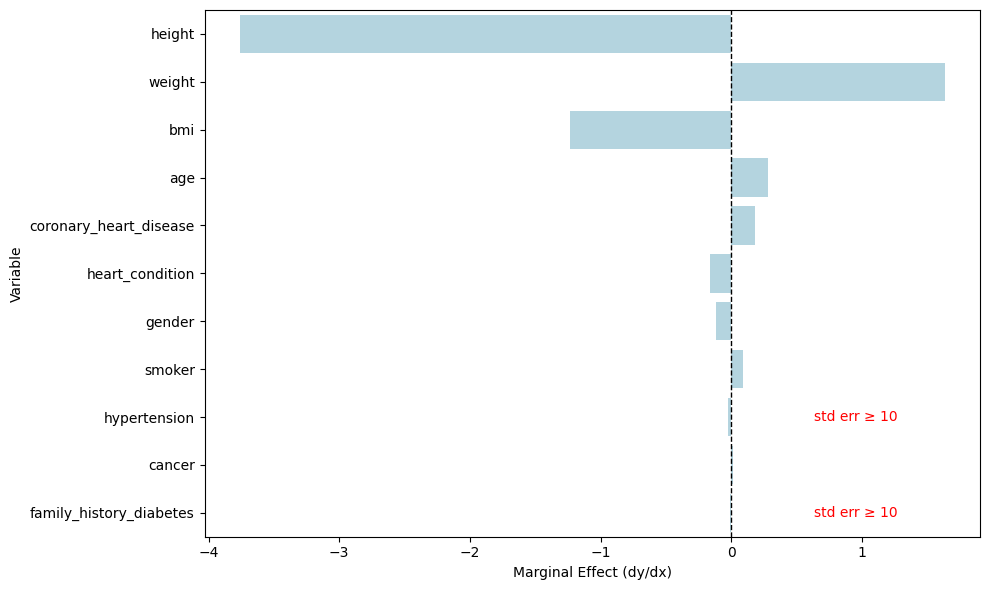

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the marginal effects values from the marginal effects summary
marginal_effects_df = marginal_effects.summary_frame()

# Step 2: Filter for the first 11 regressors (the original variables, not polynomial or interaction terms)
original_vars = ['age', 'coronary_heart_disease', 'weight', 'bmi', 'height',
                 'hypertension', 'heart_condition', 'cancer',
                 'family_history_diabetes', 'smoker', 'gender']

marginal_effects_original = marginal_effects_df.loc[original_vars]
me_original_clean = marginal_effects_original.reindex(marginal_effects_original['dy/dx'].abs().sort_values(ascending=False).index)

# Step 4: Calculate error bars (based on the 5% confidence intervals, i.e., 95% coverage in total)
# 5% confidence interval roughly corresponds to 1.645 * std err (instead of 1.96 for 95% CI)
error_bars = me_original_clean['Std. Err.'].apply(lambda x: 1.96 * x if x <= 10 else 0)

# Step 5: Plot the marginal effects as a bar chart with 5% confidence interval error bars using seaborn
plt.figure(figsize=(10, 6))

# Using sns.barplot with custom error bars for 5% CI and capsize
ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index,
                 estimator=np.mean, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')

# Step 6: Add labels for elements with std error > 10
for i, row in me_original_clean.iterrows():
    if row['Std. Err.'] > 10:
        plt.text(max(me_original_clean['dy/dx']) - 1, i, 'std err ≥ 10', va='center', ha='left', color='red', fontsize=10)

# Customizing the plot
#plt.title('Marginal Effects of Variables on the Probability of Diabetes (with 5% CI)')
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Variable')

# Add vertical line at 0 for reference
plt.axvline(x=0, color='black', linestyle='--', lw=1)

# Display the plot
plt.tight_layout()
plt.savefig('../output/logistic_regression_marginal_effects_balanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

#### On imbalanced dataset

In [ ]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split

# Step 3: Create interaction terms and polynomial features (degree 2)
# Apply PolynomialFeatures to both continuous and binary variables
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 4: Scale only the continuous variables
scaler = StandardScaler()

# Extract continuous features from the polynomial transformation
continuous_indices = [i for i, col in enumerate(poly.get_feature_names_out(X.columns))
                      if any(var in col for var in continuous_vars)]
binary_indices = [i for i in range(len(poly.get_feature_names_out(X.columns))) if i not in continuous_indices]

# Scale only continuous variables in the transformed data
X_train_poly_continuous = X_train_poly[:, continuous_indices]
X_test_poly_continuous = X_test_poly[:, continuous_indices]

# Apply scaling to continuous features
X_train_poly_continuous_scaled = scaler.fit_transform(X_train_poly_continuous)
X_test_poly_continuous_scaled = scaler.transform(X_test_poly_continuous)

# Rebuild the full dataset, keeping the binary variables unscaled
X_train_scaled = X_train_poly.copy()
X_train_scaled[:, continuous_indices] = X_train_poly_continuous_scaled

X_test_scaled = X_test_poly.copy()
X_test_scaled[:, continuous_indices] = X_test_poly_continuous_scaled

# Step 5: Convert to DataFrame and add column names
# Get the feature names from PolynomialFeatures
feature_names = poly.get_feature_names_out(X.columns)

# Create DataFrame for scaled data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Step 6: Add a constant term for the intercept
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

# Step 7: Reset indices to ensure alignment between X and y
X_train_scaled_df = X_train_scaled_df.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Step 8: Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_scaled_df)
result = logit_model.fit()

# Step 9: Display the regression summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.255256
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                22749
Model:                          Logit   Df Residuals:                    22678
Method:                           MLE   Df Model:                           70
Date:                Tue, 05 Nov 2024   Pseudo R-squ.:                  0.2476
Time:                        00:38:44   Log-Likelihood:                -5806.8
converged:                       True   LL-Null:                       -7717.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                               

In [ ]:
# Step 1: Get the model coefficients, standard errors, and p-values
params = result.params  # This gives you the coefficients
standard_errors = result.bse  # This gives you the standard errors (std dev)
p_values = result.pvalues  # This gives you the p-values

# Step 2: Select the first 11 regressors (plus the constant)
selected_params = params[:12]  # The first 11 regressors plus the constant
selected_standard_errors = standard_errors[:12]  # The standard errors for these
selected_p_values = p_values[:12]  # The p-values for these

# Step 3: Create a DataFrame to display the results, including p-values
summary_df = pd.DataFrame({
    'Regressor': selected_params.index,
    'Coefficient': selected_params.values,
    'Standard Error': selected_standard_errors.values,
    'p-value': selected_p_values.values
})

# Display the result
print(summary_df)

                  Regressor  Coefficient  Standard Error       p-value
0                     const    -6.023707    6.229595e-01  4.063601e-22
1                       age     2.662820    4.390525e-01  1.320170e-09
2    coronary_heart_disease     1.846402             NaN           NaN
3                    weight    -3.348646    1.231683e+00  6.552796e-03
4                       bmi     4.387371    9.611715e-01  5.004287e-06
5                    height     3.521678    1.523888e+00  2.083386e-02
6              hypertension     0.679289             NaN           NaN
7           heart_condition    -0.032035    2.197094e+08  1.000000e+00
8                    cancer     0.917756    3.339586e+13  1.000000e+00
9   family_history_diabetes     0.613101             NaN           NaN
10                   smoker     0.375714             NaN           NaN
11                   gender     0.898771             NaN           NaN


In [ ]:
# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.5).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")

# Step 13: Calculate the accuracy score
accuracy = accuracy_score(y_test, logit_preds_test)
print(f"Accuracy (Logit Model on Test Data): {accuracy:.4f}")

F1 Score (Logit Model on Test Data): 0.1984
Accuracy (Logit Model on Test Data): 0.8939


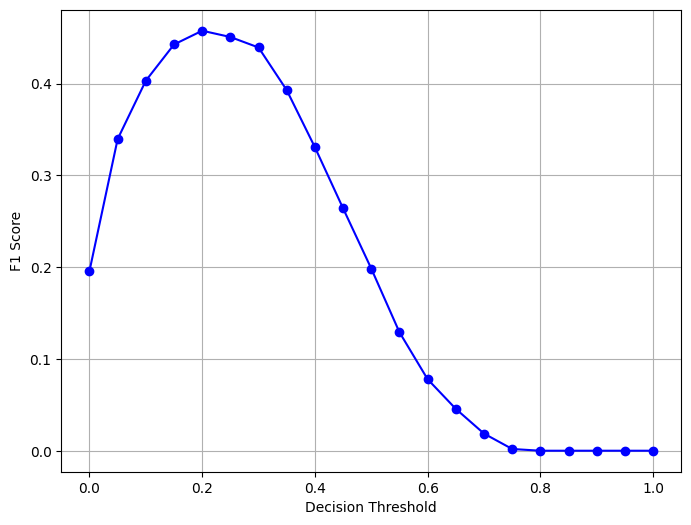

Best Threshold: 0.20, Best F1 Score: 0.4577


In [ ]:
# Step 11: Define thresholds and calculate F1 scores at each threshold
thresholds = np.arange(0, 1.05, 0.05)
f1_scores = []

for threshold in thresholds:
    # Step 12: Convert predicted probabilities to binary using the threshold
    logit_preds_test = (logit_probs_test >= threshold).astype(int)

    # Calculate the F1 score for the current threshold
    f1 = f1_score(y_test, logit_preds_test)
    f1_scores.append(f1)

# Step 13: Plot the evolution of F1 score for different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', color='blue')
#plt.title('F1 Score vs. Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.savefig('../output/f1_score_vs_threshold_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 14: Find the threshold with the maximum F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1_score:.4f}")

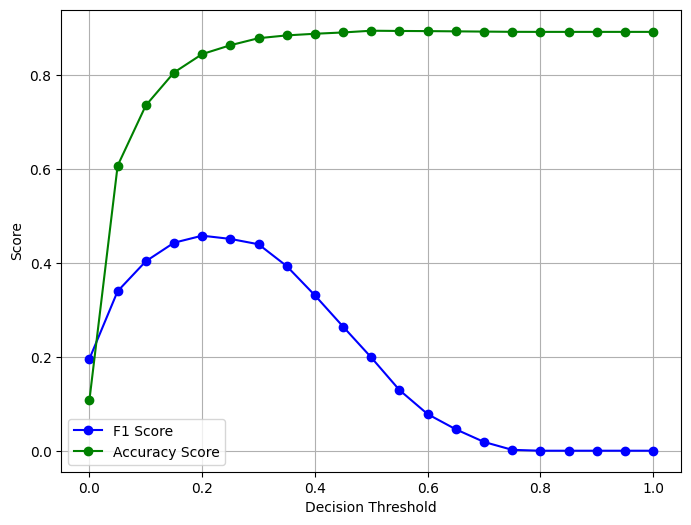

Best Threshold for F1 Score: 0.20, Best F1 Score: 0.4577
Best Threshold for Accuracy: 0.50, Best Accuracy Score: 0.8939


In [ ]:
from sklearn.metrics import accuracy_score

# Step 11: Define thresholds and calculate F1 and accuracy scores at each threshold
thresholds = np.arange(0, 1.05, 0.05)
f1_scores = []
accuracy_scores = []

for threshold in thresholds:
    # Step 12: Convert predicted probabilities to binary using the threshold
    logit_preds_test = (logit_probs_test >= threshold).astype(int)

    # Calculate the F1 score for the current threshold
    f1 = f1_score(y_test, logit_preds_test)
    f1_scores.append(f1)

    # Calculate the accuracy score for the current threshold
    accuracy = accuracy_score(y_test, logit_preds_test)
    accuracy_scores.append(accuracy)

# Step 13: Plot the evolution of F1 and accuracy scores for different thresholds
plt.figure(figsize=(8, 6))

# Plot F1 scores
plt.plot(thresholds, f1_scores, marker='o', color='blue', label='F1 Score')

# Plot accuracy scores
plt.plot(thresholds, accuracy_scores, marker='o', color='green', label='Accuracy Score')

plt.xlabel('Decision Threshold')
plt.ylabel('Score')
#plt.title('F1 Score and Accuracy vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.savefig('../output/f1_and_accuracy_vs_threshold_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 14: Find the threshold with the maximum F1 score
best_threshold_f1 = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best Threshold for F1 Score: {best_threshold_f1:.2f}, Best F1 Score: {best_f1_score:.4f}")

# Step 15: Find the threshold with the maximum accuracy
best_threshold_accuracy = thresholds[np.argmax(accuracy_scores)]
best_accuracy_score = max(accuracy_scores)

print(f"Best Threshold for Accuracy: {best_threshold_accuracy:.2f}, Best Accuracy Score: {best_accuracy_score:.4f}")

F1 Score (Logit Model on Test Data): 0.4577
AUC Score (Logit Model on Test Data): 0.8491


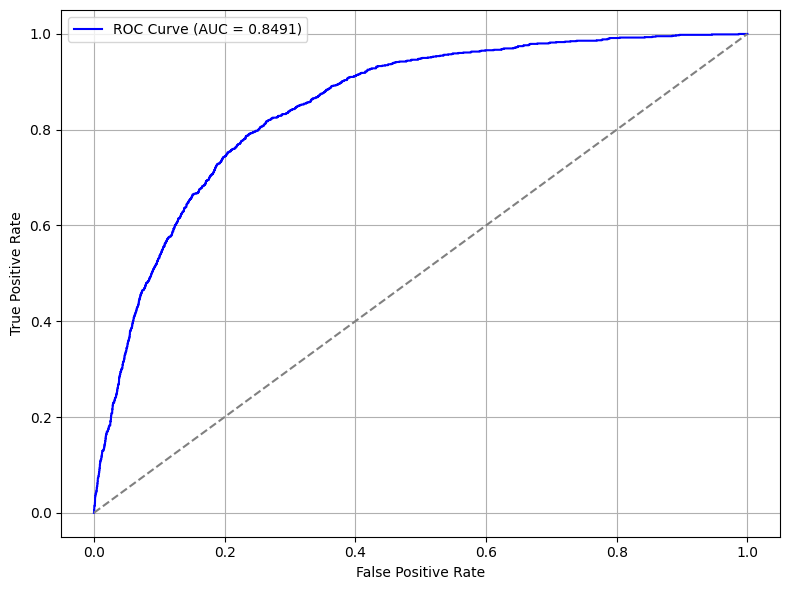

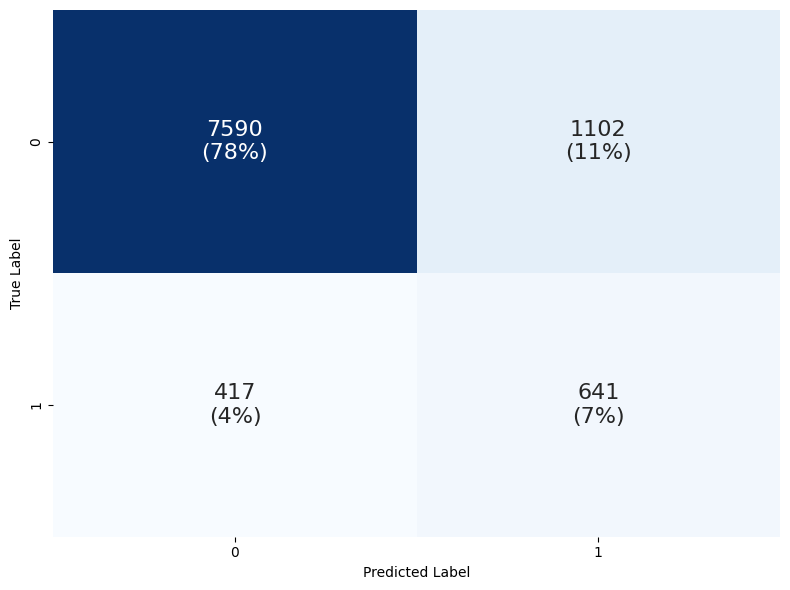

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 10: Predict probabilities on the test set
logit_probs_test = result.predict(X_test_scaled_df)

# Step 11: Convert predicted probabilities to binary (0 or 1) using a threshold of 0.5
logit_preds_test = (logit_probs_test > 0.20).astype(int)

# Step 12: Calculate the F1 score
f1 = f1_score(y_test, logit_preds_test)
print(f"F1 Score (Logit Model on Test Data): {f1:.4f}")


# Step 13: ROC Curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, logit_probs_test)  # Get False Positive Rate and True Positive Rate
auc_score = roc_auc_score(y_test, logit_probs_test)  # AUC score
print(f"AUC Score (Logit Model on Test Data): {auc_score:.4f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Dashed diagonal line
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../output/logistic_regression_ROC_curve_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()


# Step 14: Confusion Matrix
cm = confusion_matrix(y_test, logit_preds_test)

# Step 15: Prepare counts and percentages for the confusion matrix
group_counts = [f"{value:0.0f}" for value in cm.flatten()]
group_percentages = [f"({value:.0%})" for value in cm.flatten() / np.sum(cm)]

# Step 16: Create combined labels with counts and percentages in brackets
labels = [f"{count}\n{percent}" for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Step 17: Plot the confusion matrix using seaborn heatmap with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Customizing the plot
#plt.title('Confusion Matrix with Counts and Percentages')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Display the plot
plt.tight_layout()
plt.savefig('../output/logistic_regression_confusion_matrix_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# Step 15: Calculate the marginal effects
marginal_effects = result.get_margeff(at='overall', method='dydx')  # Average marginal effects

# Step 16: Display the marginal effects summary
print(marginal_effects.summary())

        Logit Marginal Effects       
Dep. Variable:               diabetes
Method:                          dydx
At:                           overall
                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
age                                                0.2034   1.71e+05   1.19e-06      1.000   -3.35e+05    3.35e+05
coronary_heart_disease                             0.1410        nan        nan        nan         nan         nan
weight                                            -0.2557        nan        nan        nan         nan         nan
bmi                                                0.3351        nan        nan        nan         nan         nan
height                                             0.2690        nan        nan        nan         nan         nan
hypertension                               

/usr/local/lib/python3.10/dist-packages/statsmodels/discrete/discrete_margins.py:343: RuntimeWarning: invalid value encountered in sqrt
  return cov_me, np.sqrt(np.diag(cov_me))


<ipython-input-29-a4973b2f263c>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index,


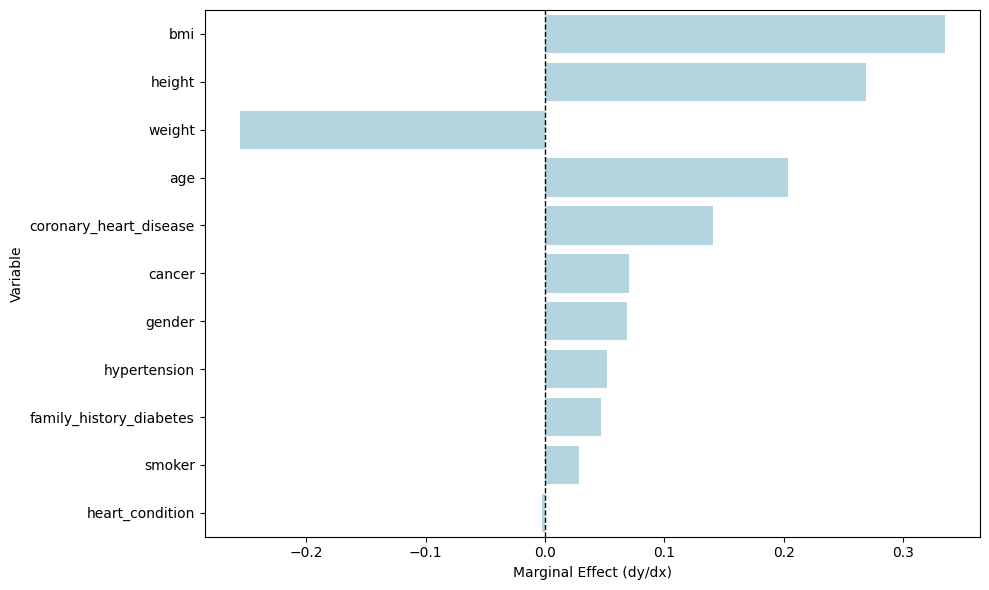

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get the marginal effects values from the marginal effects summary
marginal_effects_df = marginal_effects.summary_frame()

# Step 2: Filter for the first 11 regressors (the original variables, not polynomial or interaction terms)
original_vars = ['age', 'coronary_heart_disease', 'weight', 'bmi', 'height',
                 'hypertension', 'heart_condition', 'cancer',
                 'family_history_diabetes', 'smoker', 'gender']

marginal_effects_original = marginal_effects_df.loc[original_vars]
me_original_clean = marginal_effects_original.reindex(marginal_effects_original['dy/dx'].abs().sort_values(ascending=False).index)

# Step 4: Calculate error bars (based on the 5% confidence intervals, i.e., 95% coverage in total)
# 5% confidence interval roughly corresponds to 1.645 * std err (instead of 1.96 for 95% CI)
error_bars = me_original_clean['Std. Err.'].apply(lambda x: 1.96 * x if x <= 10 else 0)

# Step 5: Plot the marginal effects as a bar chart with 5% confidence interval error bars using seaborn
plt.figure(figsize=(10, 6))

# Using sns.barplot with custom error bars for 5% CI and capsize
ax = sns.barplot(x=me_original_clean['dy/dx'], y=me_original_clean.index,
                 estimator=np.mean, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')

# Step 6: Add labels for elements with std error > 10
#for i, row in me_original_clean.iterrows():
#    if row['Std. Err.'] > 10:
#        plt.text(max(me_original_clean['dy/dx']) - 0.02, i, 'std err ≥ 1E4', va='center', ha='left', color='red', fontsize=10)

# Customizing the plot
#plt.title('Marginal Effects of Variables on the Probability of Diabetes (with 5% CI)')
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Variable')

# Add vertical line at 0 for reference
plt.axvline(x=0, color='black', linestyle='--', lw=1)

# Display the plot
plt.tight_layout()
plt.savefig('../output/logistic_regression_marginal_effects_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-30-00a940b41563>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=top_10_me['dy/dx'], y=top_10_me.index, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')


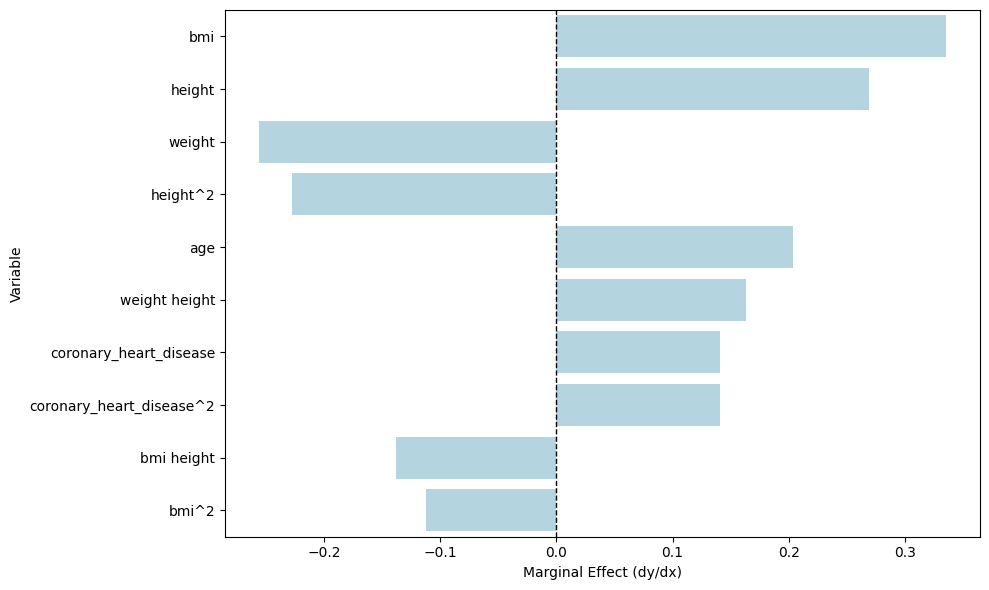

In [ ]:
# Step 1: Get the marginal effects values from the marginal effects summary
marginal_effects_df = marginal_effects.summary_frame()

# Step 2: Sort all variables (including polynomial and interaction terms) by absolute marginal effect values
me_clean = marginal_effects_df.reindex(marginal_effects_df['dy/dx'].abs().sort_values(ascending=False).index)

# Step 3: Select the top 10 variables based on absolute marginal effects
top_10_me = me_clean.head(10)

# Step 4: Calculate error bars (based on the 5% confidence intervals)
error_bars = top_10_me['Std. Err.'].apply(lambda x: 1.645 * x if x <= 10 else 0)

# Step 5: Plot the marginal effects as a bar chart with 5% confidence interval error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_me['dy/dx'], y=top_10_me.index, ci=None, xerr=error_bars, capsize=0.2, color='lightblue')

# Customizing the plot
plt.xlabel('Marginal Effect (dy/dx)')
plt.ylabel('Variable')
plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.tight_layout()
plt.savefig('../output/top_10_marginal_effects_imbalanced_2017.png', dpi=300, bbox_inches='tight')
plt.show()

### Random forests

F1 Score (Random Forest): 0.3186
Accuracy (Random Forest): 0.8135
AUC Score (Random Forest): 0.7648


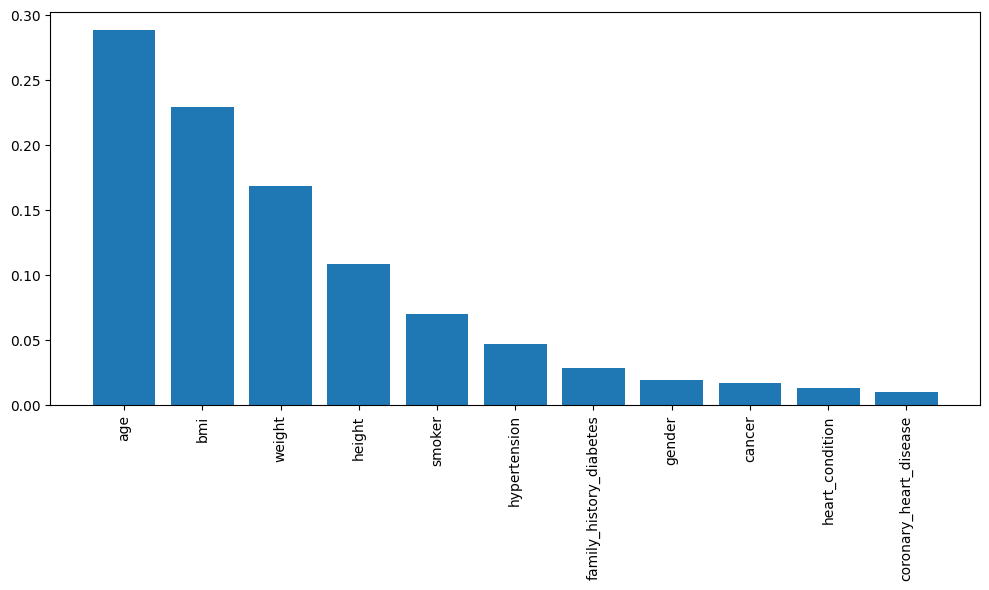

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Step 3: Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Fit the model to the training data
rf_model.fit(X_train_res, y_train_res)

# Step 5: Predict probabilities on the test set
rf_probs_test = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (diabetes=1)

# Step 6: Predict the class labels (0 or 1)
rf_preds_test = rf_model.predict(X_test)

# Step 7: Calculate F1 Score, Accuracy, and AUC
f1_rf = f1_score(y_test, rf_preds_test)
accuracy_rf = accuracy_score(y_test, rf_preds_test)
auc_rf = roc_auc_score(y_test, rf_probs_test)

print(f"F1 Score (Random Forest): {f1_rf:.4f}")
print(f"Accuracy (Random Forest): {accuracy_rf:.4f}")
print(f"AUC Score (Random Forest): {auc_rf:.4f}")

# Step 8: Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
#plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.savefig('../output/random_forest_feature_importance_2017.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Evaluate on the test set
best_rf_model = grid_search.best_estimator_
f1_best_rf = f1_score(y_test, best_rf_model.predict(X_test))
print(f"F1 Score after hyperparameter tuning: {f1_best_rf:.4f}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
454 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py"

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
F1 Score after hyperparameter tuning: 0.3100


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model with the specified parameters and enable OOB scoring
rf_model_oob = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    oob_score=True,  # Enable out-of-bag error computation
    random_state=42
)

# Train the model on the training set
rf_model_oob.fit(X_train_res, y_train_res)

# Compute the out-of-bag error
oob_error = 1 - rf_model_oob.oob_score_

print(f"OOB Score: {rf_model_oob.oob_score_:.4f}")

OOB Score: 0.8887


F1 Score (Random Forest with optimized hyperparameters): 0.3100
Accuracy (Random Forest with optimized hyperparameters): 0.8091
AUC Score (Random Forest with optimized hyperparameters): 0.7661


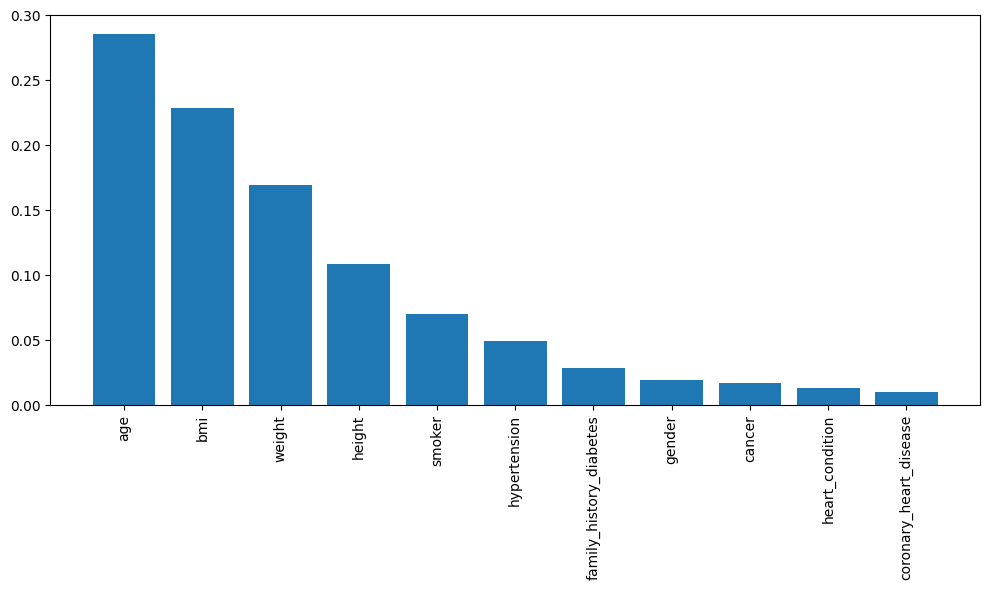

In [ ]:
# Step 3: Create a Random Forest model
rf_model_opt = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    oob_score=True,  # Enable out-of-bag error computation
    random_state=42
)

# Step 4: Fit the model to the training data
rf_model_opt.fit(X_train_res, y_train_res)

# Step 5: Predict probabilities on the test set
rf_probs_test = rf_model_opt.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (diabetes=1)

# Step 6: Predict the class labels (0 or 1)
rf_preds_test = rf_model_opt.predict(X_test)

# Step 7: Calculate F1 Score, Accuracy, and AUC
f1_rf_opt = f1_score(y_test, rf_preds_test)
accuracy_rf_opt = accuracy_score(y_test, rf_preds_test)
auc_rf_opt = roc_auc_score(y_test, rf_probs_test)

print(f"F1 Score (Random Forest with optimized hyperparameters): {f1_rf_opt:.4f}")
print(f"Accuracy (Random Forest with optimized hyperparameters): {accuracy_rf_opt:.4f}")
print(f"AUC Score (Random Forest with optimized hyperparameters): {auc_rf_opt:.4f}")

# Step 8: Plot feature importance
importances = rf_model_opt.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
#plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.savefig('../output/opt_random_forest_feature_importance_2017.png', dpi=300, bbox_inches='tight')
plt.show()

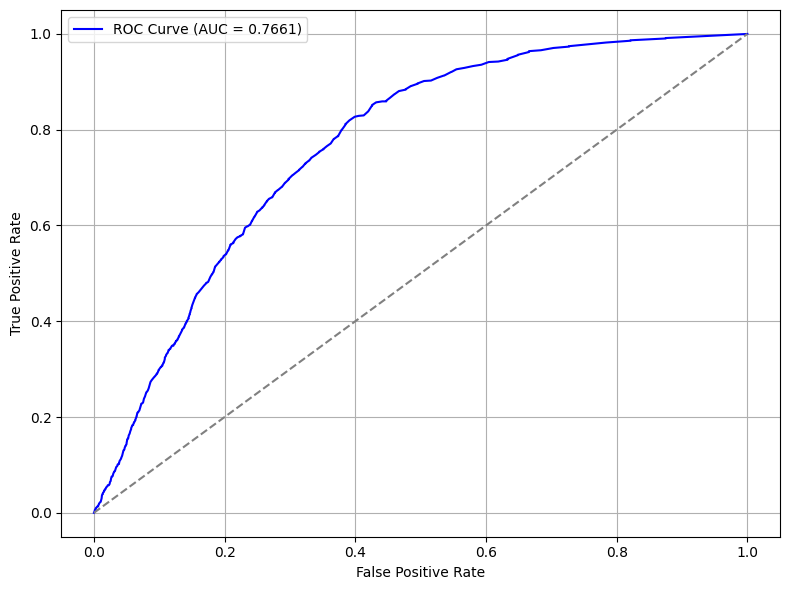

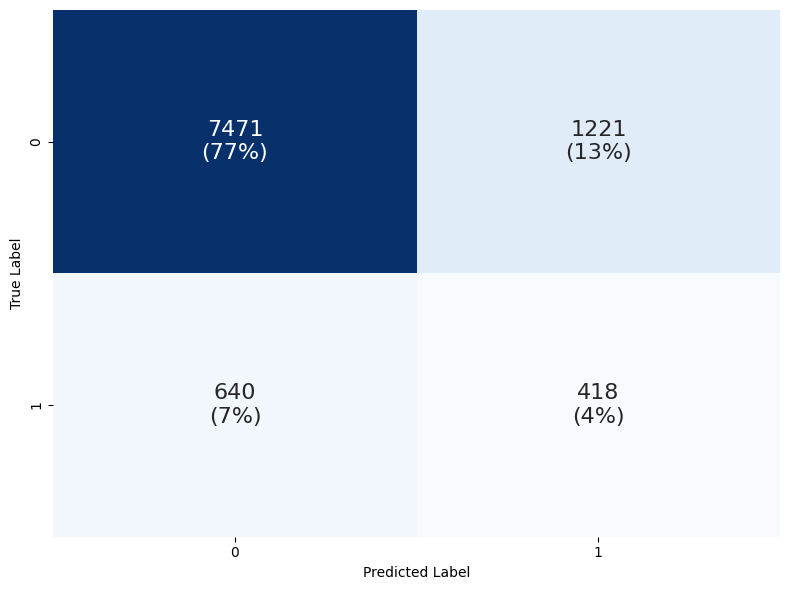

In [ ]:
# Step 9: ROC Curve and AUC score
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_probs_test)  # Get False Positive Rate and True Positive Rate
auc_rf = roc_auc_score(y_test, rf_probs_test)  # AUC score

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {auc_rf:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Dashed diagonal line
#plt.title('ROC Curve (Random Forest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../output/opt_random_forest_ROC_curve_2017.png', dpi=300, bbox_inches='tight')
plt.show()

# Step 10: Confusion Matrix for Random Forest model
cm_rf = confusion_matrix(y_test, rf_preds_test)

# Step 11: Prepare counts and percentages for the confusion matrix
group_counts = [f"{value:0.0f}" for value in cm_rf.flatten()]
group_percentages = [f"({value:.0%})" for value in cm_rf.flatten() / np.sum(cm_rf)]

# Step 12: Create combined labels with counts and percentages in brackets
labels = [f"{count}\n{percent}" for count, percent in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)

# Step 13: Plot the confusion matrix using seaborn heatmap with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Customizing the plot
#plt.title('Confusion Matrix with Counts and Percentages (Random Forest)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Display the plot
plt.tight_layout()
plt.savefig('opt_random_forest_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Stability test: no BMI in the random forest

F1 Score (Random Forest with optimized hyperparameters): 0.3164
Accuracy (Random Forest with optimized hyperparameters): 0.8032
AUC Score (Random Forest with optimized hyperparameters): 0.7524


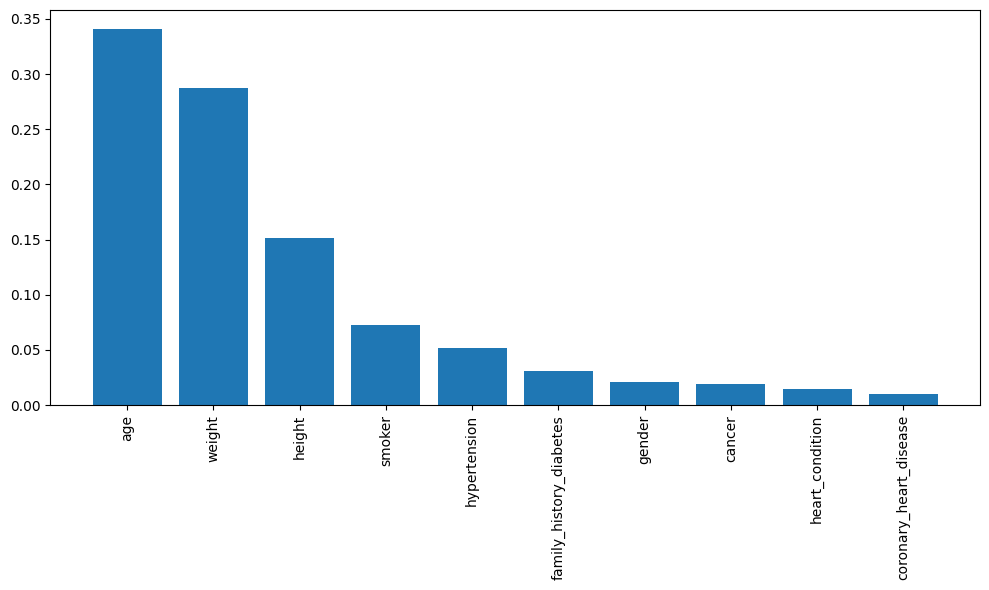

In [ ]:
# Step 3: Drop the BMI column from the training and test data
X_train_res_no_bmi = X_train_res.drop(columns=['bmi'], errors='ignore')  # Dropping 'bmi' if it exists in training data
X_test_no_bmi = X_test.drop(columns=['bmi'], errors='ignore')            # Dropping 'bmi' if it exists in test data

# Step 4: Create a Random Forest model with optimized hyperparameters
rf_model_opt = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    oob_score=True,  # Enable out-of-bag error computation
    random_state=42
)

# Step 5: Fit the model to the training data without BMI
rf_model_opt.fit(X_train_res_no_bmi, y_train_res)

# Step 6: Predict probabilities on the test set without BMI
rf_probs_test = rf_model_opt.predict_proba(X_test_no_bmi)[:, 1]  # Probabilities for the positive class (diabetes=1)

# Step 7: Predict the class labels (0 or 1)
rf_preds_test = rf_model_opt.predict(X_test_no_bmi)

# Step 8: Calculate F1 Score, Accuracy, and AUC
f1_rf_opt = f1_score(y_test, rf_preds_test)
accuracy_rf_opt = accuracy_score(y_test, rf_preds_test)
auc_rf_opt = roc_auc_score(y_test, rf_probs_test)

print(f"F1 Score (Random Forest with optimized hyperparameters): {f1_rf_opt:.4f}")
print(f"Accuracy (Random Forest with optimized hyperparameters): {accuracy_rf_opt:.4f}")
print(f"AUC Score (Random Forest with optimized hyperparameters): {auc_rf_opt:.4f}")

# Step 9: Plot feature importance
importances = rf_model_opt.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train_res_no_bmi.columns  # Adjusted to reflect the columns in X_train_res_no_bmi after dropping BMI

plt.figure(figsize=(10, 6))
plt.bar(range(X_train_res_no_bmi.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_res_no_bmi.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.savefig('opt_random_forest_feature_importance_no_bmi.png', dpi=300, bbox_inches='tight')
plt.show()